In [2]:
# Read packedges

import pandas as pd
import pandas.testing as tm
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.api as sm
import statsmodels.discrete.discrete_model as dm

from patsy import dmatrices
import statsmodels.graphics.tsaplots as tsa


from scipy.fft import fft, ifft, fftfreq

import statsmodels.formula.api as smf
from statsmodels.tsa.stattools import acf

import itertools
from itertools import combinations, chain

from scipy.stats import pearsonr

import re

import functions

import early_warning_detection_functions

from datetime import datetime

import pymannkendall as mk

import math

import trend_timeseries

from scipy.stats import friedmanchisquare

from sklearn.metrics import r2_score

from pmdarima.preprocessing import FourierFeaturizer
from pmdarima.datasets import load_wineind
from sklearn.linear_model import LinearRegression


# Read processed data

In [3]:
df = pd.read_parquet('//home/juliane.oliveira/workspace/Bivariate_Anomaly_Detection_Primary_Health_Care_Drug_Selling_ILI_surveillance/Results/data_manuscript_otc_phc_imed.parquet')



In [4]:
df.columns

Index(['sigla_uf', 'co_uf', 'nm_uf', 'co_imed', 'Nome_imed', 'year_week',
       'year_week_ts', 'epidemi_cal_start', 'epidemi_cal_end', 'atend_ivas',
       'num_otc_ivas', 'atend_ivas_4', 'num_otc_ivas_4', 'dtrend_ivas_negbi',
       'dtrend_otc_negbi', 'p_values_negbi_atend_ivas_4',
       'p_values_negbi_num_otc_ivas_4', 'p_value_ivas_negbi_friedman',
       'p_value_otc_negbi_friedman', 'phc_4_lag_1', 'phc_4_lag_2',
       'phc_4_lag_3', 'otc_4_lag_1', 'otc_4_lag_2', 'otc_4_lag_3'],
      dtype='object')

In [5]:
df.co_imed.nunique()

510

# Run regressions

## Early warning on PHC series alone

### Cities without trend and sezonality

In [6]:
# select cities without trend and sezonality in PHC

df1 = df[(df.p_value_ivas_negbi_friedman >= 0.05) & (df.p_values_negbi_atend_ivas_4 >= 0.05)]

print('number of imed without trend and sezonality', df1.co_imed.nunique(), 'percentage', round(df1.co_imed.nunique()*100/510,1) )

number of imed without trend and sezonality 102 percentage 20.0


In [7]:
lags_y = range(1, 4)  # Example: Using lags 1 to 4 for y_t
dependent_variable = 'atend_ivas_4'  # dependent variable

def lags_comb(variable, lags_variable):
    """Create cumulative lag combinations for a given variable."""
    lags_variable_comb = [f'{variable}_{lag}' for lag in lags_variable]
    cumulative_sums_var = [' + '.join(lags_variable_comb[:i]) for i in range(1, len(lags_variable_comb) + 1)]
    return cumulative_sums_var

# Generate lagged combinations
lags_y_comb = lags_comb('phc_4_lag', lags_y)
#lags_x_comb = lags_comb('otc_4_lag', lags_x)


formulas = []

# Iterate over all combinations and create formula strings
for terms in lags_y_comb:
    components = [terms]
    # Remove empty strings and join components
    formula_components = ' + '.join(filter(None, components))
    formula = f'{dependent_variable} ~ {formula_components}'
    formulas.append(formula)


## Keep the best model formulas and AIC

lst = []

for code in df1.co_imed.unique():

    #print(code)

    data = df1[df1.co_imed == code]

    # Placeholder for the best model
    best_model = None
    best_aic = float('inf')
    best_formula = None

    # Loop through all formulas to find the best model based on AIC
    for formula in formulas:
        
        # Fit the model
        alpha = 1
        model = smf.glm(formula=formula, data=data, family=sm.families.NegativeBinomial(alpha=alpha)).fit()
        
        # Check the AIC of the current model
        current_aic = model.aic
        
        # Update the best model if the current model has a lower AIC
        if current_aic < best_aic:
            best_aic = current_aic
            best_model = model
            best_formula = formula

    data = data.assign(best_formula = best_formula)
    data = data.assign(best_aic = best_aic)
    
    lst.append(data)

lst_dfs_cities1 = lst

#### save predicted values, upperbound and warning columns

# we know the best model that adjust to the data of each municipality. Thus:

lst = []

for data in lst_dfs_cities1:
    # Fit the model
    alpha = 0.1
    model = smf.glm(formula=data.best_formula.iloc[0], data=data, family=sm.families.NegativeBinomial(alpha=alpha)).fit()

    # Extract fitted values and residuals
    fitted_values = model.fittedvalues
    residuals = model.resid_deviance
    
    sigma = np.std(residuals)
    sigma_ = np.std(fitted_values)
    sigma_t = fitted_values.rolling(window=5).std()
    
    data = data.assign(fitted_values_phc_only = fitted_values,
                      residuals_phc_only = residuals,
                      sigma_phc_only = sigma,
                      sigma__phc_only = sigma_,
                      sigma_t_phc_only = sigma_t)
    
    lst.append(data)
    
lst_dfs_cities1 = lst


lst = []
for i in range(len(lst_dfs_cities1)):
    
    data = lst_dfs_cities1[i]
    
    # Calculate control limits for the original series
    w = 1 #data.w_best.iloc[0]
    
    data = data.assign(UCL_phc_only = data.fitted_values_phc_only + w * data.sigma_t_phc_only,
                      LCL_phc_only = data.fitted_values_phc_only - w * data.sigma_t_phc_only)

    data = data.assign(out_of_limits_above_phc_only = (data['atend_ivas_4'] >= data.UCL_phc_only).astype(int),
                       out_of_limits_below_phc_only = (data['atend_ivas_4'] < data.LCL_phc_only).astype(int)
                       )
    
    lst.append(data)
    
lst_dfs_cities1 = lst   

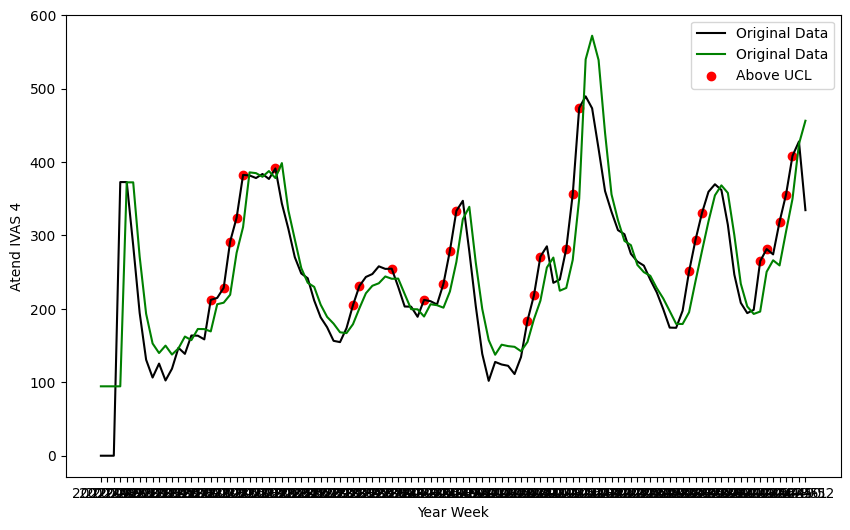

In [8]:
dta = lst_dfs_cities1[10]

# Create the plot
plt.figure(figsize=(10, 6))

# Plot the original data
plt.plot(dta.year_week, dta['atend_ivas_4'], label='Original Data', color='black')
# Plot the original data
plt.plot(dta.year_week, dta['fitted_values_phc_only'], label='Original Data', color='green')

# Create boolean masks for points outside limits
out_of_limits_above = dta['atend_ivas_4'] >= dta['UCL_phc_only']
out_of_limits_below = dta['atend_ivas_4'] < dta['LCL_phc_only']

# Scatter plot for points above UCL
plt.scatter(
    dta['year_week'][out_of_limits_above],  # Ensure the index aligns
    dta['atend_ivas_4'][out_of_limits_above],  # Use the same DataFrame
    color='red',
    label='Above UCL'
)

# Optional: Scatter plot for points below LCL
#plt.scatter(
#    dta['year_week'][out_of_limits_below],
#    dta['atend_ivas_4'][out_of_limits_below],
#   color='blue',
#    label='Below LCL'
#)

# Add labels and legend
plt.xlabel('Year Week')
plt.ylabel('Atend IVAS 4')
plt.legend()
plt.show()


### Cities with trend and without sezonality

In [10]:
# select cities without trend and sezonality in PHC

df2 = df[(df.p_value_ivas_negbi_friedman >= 0.05) & (df.p_values_negbi_atend_ivas_4 < 0.05)]

print('number of imediate with trend and without sezonality', df2.co_imed.nunique(), 'percentage', round(df2.co_imed.nunique()*100/510,1) )

number of imediate with trend and without sezonality 9 percentage 1.8


In [12]:
lags_y = range(1, 4)  # Example: Using lags 1 to 4 for y_t
dependent_variable = 'atend_ivas_4'  # dependent variable

def lags_comb(variable, lags_variable):
    """Create cumulative lag combinations for a given variable."""
    lags_variable_comb = [f'{variable}_{lag}' for lag in lags_variable]
    cumulative_sums_var = [' + '.join(lags_variable_comb[:i]) for i in range(1, len(lags_variable_comb) + 1)]
    return cumulative_sums_var

# Generate lagged combinations
lags_y_comb = lags_comb('phc_4_lag', lags_y)
#lags_x_comb = lags_comb('otc_4_lag', lags_x)


formulas = []

# Iterate over all combinations and create formula strings
for terms in lags_y_comb:
    components = [terms]
    # Remove empty strings and join components
    formula_components = 'time_trend + ' + ' + '.join(filter(None, components))
    formula = f'{dependent_variable} ~ {formula_components}'
    formulas.append(formula)


## Keep the best model formulas and AIC

lst = []

for code in df2.co_imed.unique():

    #print(code)

    data = df2[df2.co_imed == code]

    data = data.assign(time_trend = np.arange(len(data)))

    # Placeholder for the best model
    best_model = None
    best_aic = float('inf')
    best_formula = None

    # Loop through all formulas to find the best model based on AIC
    for formula in formulas:
        
        # Fit the model
        alpha = 1
        model = smf.glm(formula=formula, data=data, family=sm.families.NegativeBinomial(alpha=alpha)).fit()
        
        # Check the AIC of the current model
        current_aic = model.aic
        
        # Update the best model if the current model has a lower AIC
        if current_aic < best_aic:
            best_aic = current_aic
            best_model = model
            best_formula = formula

    data = data.assign(best_formula = best_formula)
    data = data.assign(best_aic = best_aic)
    
    lst.append(data)

lst_dfs_cities2 = lst

#### save predicted values, upperbound and warning columns

# we know the best model that adjust to the data of each municipality. Thus:

lst = []

for data in lst_dfs_cities2:
    # Fit the model
    alpha = 0.1
    model = smf.glm(formula=data.best_formula.iloc[0], data=data, family=sm.families.NegativeBinomial(alpha=alpha)).fit()

    # Extract fitted values and residuals
    fitted_values = model.fittedvalues
    residuals = model.resid_deviance
    
    sigma = np.std(residuals)
    sigma_ = np.std(fitted_values)
    sigma_t = fitted_values.rolling(window=5).std()
    
    data = data.assign(fitted_values_phc_only = fitted_values,
                      residuals_phc_only = residuals,
                      sigma_phc_only = sigma,
                      sigma__phc_only = sigma_,
                      sigma_t_phc_only = sigma_t)
    
    lst.append(data)
    
lst_dfs_cities2 = lst


lst = []
for i in range(len(lst_dfs_cities2)):
    
    data = lst_dfs_cities2[i]
    
    # Calculate control limits for the original series
    w = 1 #data.w_best.iloc[0]
    
    data = data.assign(UCL_phc_only = data.fitted_values_phc_only + w * data.sigma_t_phc_only,
                      LCL_phc_only = data.fitted_values_phc_only - w * data.sigma_t_phc_only)

    data = data.assign(out_of_limits_above_phc_only = (data['atend_ivas_4'] >= data.UCL_phc_only).astype(int),
                       out_of_limits_below_phc_only = (data['atend_ivas_4'] < data.LCL_phc_only).astype(int)
                       )
    
    lst.append(data)
    
lst_dfs_cities2 = lst   

### Cities without trend and with sezonality

In [13]:
# select cities without trend and sezonality in PHC

df3 = df[(df.p_value_ivas_negbi_friedman < 0.05) & (df.p_values_negbi_atend_ivas_4 >= 0.05)]

print('number of imediate without trend and with sezonality', df3.co_imed.nunique(), 'percentage', round(df3.co_imed.nunique()*100/510,1) )

number of imediate without trend and with sezonality 370 percentage 72.5


In [14]:
lst_dfs_cities3 = []

for code in df3.co_imed.unique():
    
    set_muni = df3[df3.co_imed == code]

    lst_dfs_cities3.append(set_muni)

lst_dfs_cities3 = early_warning_detection_functions.harmonic(lst_dfs_cities3, 'atend_ivas_4')

In [15]:
lags_y = range(1, 4)  # Example: Using lags 1 to 4 for y_t
dependent_variable = 'atend_ivas_4'  # dependent variable

def lags_comb(variable, lags_variable):
    """Create cumulative lag combinations for a given variable."""
    lags_variable_comb = [f'{variable}_{lag}' for lag in lags_variable]
    cumulative_sums_var = [' + '.join(lags_variable_comb[:i]) for i in range(1, len(lags_variable_comb) + 1)]
    return cumulative_sums_var

# Generate lagged combinations
lags_y_comb = lags_comb('phc_4_lag', lags_y)
#lags_x_comb = lags_comb('otc_4_lag', lags_x)


formulas = []

# Iterate over all combinations and create formula strings
for terms in lags_y_comb:
    components = [terms]
    # Remove empty strings and join components
    formula_components = 'Reconstructed + ' + ' + '.join(filter(None, components))
    formula = f'{dependent_variable} ~ {formula_components}'
    formulas.append(formula)


## Keep the best model formulas and AIC

lst = []

for data in lst_dfs_cities3:

    # Placeholder for the best model
    best_model = None
    best_aic = float('inf')
    best_formula = None

    # Loop through all formulas to find the best model based on AIC
    for formula in formulas:
        
        # Fit the model
        alpha = 1
        model = smf.glm(formula=formula, data=data, family=sm.families.NegativeBinomial(alpha=alpha)).fit()
        
        # Check the AIC of the current model
        current_aic = model.aic
        
        # Update the best model if the current model has a lower AIC
        if current_aic < best_aic:
            best_aic = current_aic
            best_model = model
            best_formula = formula

    data = data.assign(best_formula = best_formula)
    data = data.assign(best_aic = best_aic)
    
    lst.append(data)

lst_dfs_cities3 = lst

#### save predicted values, upperbound and warning columns

# we know the best model that adjust to the data of each municipality. Thus:

lst = []

for data in lst_dfs_cities3:
    # Fit the model
    alpha = 0.1
    model = smf.glm(formula=data.best_formula.iloc[0], data=data, family=sm.families.NegativeBinomial(alpha=alpha)).fit()

    # Extract fitted values and residuals
    fitted_values = model.fittedvalues
    residuals = model.resid_deviance
    
    sigma = np.std(residuals)
    sigma_ = np.std(fitted_values)
    sigma_t = fitted_values.rolling(window=5).std()
    
    data = data.assign(fitted_values_phc_only = fitted_values,
                      residuals_phc_only = residuals,
                      sigma_phc_only = sigma,
                      sigma__phc_only = sigma_,
                      sigma_t_phc_only = sigma_t)
    
    lst.append(data)
    
lst_dfs_cities3 = lst


lst = []
for i in range(len(lst_dfs_cities3)):
    
    data = lst_dfs_cities3[i]
    
    # Calculate control limits for the original series
    w = 1 #data.w_best.iloc[0]
    
    data = data.assign(UCL_phc_only = data.fitted_values_phc_only + w * data.sigma_t_phc_only,
                      LCL_phc_only = data.fitted_values_phc_only - w * data.sigma_t_phc_only)

    data = data.assign(out_of_limits_above_phc_only = (data['atend_ivas_4'] >= data.UCL_phc_only).astype(int),
                       out_of_limits_below_phc_only = (data['atend_ivas_4'] < data.LCL_phc_only).astype(int)
                       )
    
    lst.append(data)
    
lst_dfs_cities3 = lst   

### Cities with trend and with sezonality

In [16]:
# select cities without trend and sezonality in PHC

df4 = df[(df.p_value_ivas_negbi_friedman < 0.05) & (df.p_values_negbi_atend_ivas_4 < 0.05)]

print('number of imed with trend and sezonality', df4.co_imed.nunique(), 'percentage', round(df4.co_imed.nunique()*100/510,1) )

number of imed with trend and sezonality 29 percentage 5.7


In [17]:
lst_dfs_cities4 = []

for code in df4.co_imed.unique():
    
    set_muni = df4[df4.co_imed == code]

    lst_dfs_cities4.append(set_muni)

lst_dfs_cities4 = early_warning_detection_functions.harmonic(lst_dfs_cities4, 'atend_ivas_4')

/usr/local/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [18]:
lags_y = range(1, 4)  # Example: Using lags 1 to 4 for y_t
dependent_variable = 'atend_ivas_4'  # dependent variable

def lags_comb(variable, lags_variable):
    """Create cumulative lag combinations for a given variable."""
    lags_variable_comb = [f'{variable}_{lag}' for lag in lags_variable]
    cumulative_sums_var = [' + '.join(lags_variable_comb[:i]) for i in range(1, len(lags_variable_comb) + 1)]
    return cumulative_sums_var

# Generate lagged combinations
lags_y_comb = lags_comb('phc_4_lag', lags_y)
#lags_x_comb = lags_comb('otc_4_lag', lags_x)


formulas = []

# Iterate over all combinations and create formula strings
for terms in lags_y_comb:
    components = [terms]
    # Remove empty strings and join components
    formula_components = 'time_trend + Reconstructed + ' + ' + '.join(filter(None, components))
    formula = f'{dependent_variable} ~ {formula_components}'
    formulas.append(formula)


## Keep the best model formulas and AIC

lst = []

for data in lst_dfs_cities4:

    data = data.assign(time_trend = np.arange(len(data)))

    # Placeholder for the best model
    best_model = None
    best_aic = float('inf')
    best_formula = None

    # Loop through all formulas to find the best model based on AIC
    for formula in formulas:
        
        # Fit the model
        alpha = 1
        model = smf.glm(formula=formula, data=data, family=sm.families.NegativeBinomial(alpha=alpha)).fit()
        
        # Check the AIC of the current model
        current_aic = model.aic
        
        # Update the best model if the current model has a lower AIC
        if current_aic < best_aic:
            best_aic = current_aic
            best_model = model
            best_formula = formula

    data = data.assign(best_formula = best_formula)
    data = data.assign(best_aic = best_aic)
    
    lst.append(data)

lst_dfs_cities4 = lst

#### save predicted values, upperbound and warning columns

# we know the best model that adjust to the data of each municipality. Thus:

lst = []

for data in lst_dfs_cities4:
    # Fit the model
    alpha = 0.1
    model = smf.glm(formula=data.best_formula.iloc[0], data=data, family=sm.families.NegativeBinomial(alpha=alpha)).fit()

    # Extract fitted values and residuals
    fitted_values = model.fittedvalues
    residuals = model.resid_deviance
    
    sigma = np.std(residuals)
    sigma_ = np.std(fitted_values)
    sigma_t = fitted_values.rolling(window=5).std()
    
    data = data.assign(fitted_values_phc_only = fitted_values,
                      residuals_phc_only = residuals,
                      sigma_phc_only = sigma,
                      sigma__phc_only = sigma_,
                      sigma_t_phc_only = sigma_t)
    
    lst.append(data)
    
lst_dfs_cities4 = lst


lst = []
for i in range(len(lst_dfs_cities4)):
    
    data = lst_dfs_cities4[i]
    
    # Calculate control limits for the original series
    w = 1 #data.w_best.iloc[0]
    
    data = data.assign(UCL_phc_only = data.fitted_values_phc_only + w * data.sigma_t_phc_only,
                      LCL_phc_only = data.fitted_values_phc_only - w * data.sigma_t_phc_only)

    data = data.assign(out_of_limits_above_phc_only = (data['atend_ivas_4'] >= data.UCL_phc_only).astype(int),
                       out_of_limits_below_phc_only = (data['atend_ivas_4'] < data.LCL_phc_only).astype(int)
                       )
    
    lst.append(data)
    
lst_dfs_cities4 = lst   

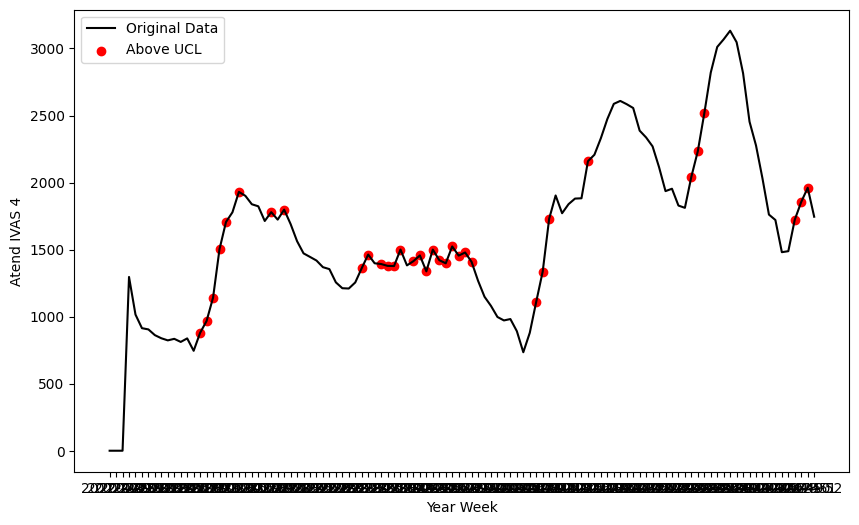

In [19]:
dta = lst_dfs_cities4[10]

# Create the plot
plt.figure(figsize=(10, 6))

# Plot the original data
plt.plot(dta.year_week, dta['atend_ivas_4'], label='Original Data', color='black')

# Create boolean masks for points outside limits
out_of_limits_above = dta['atend_ivas_4'] >= dta['UCL_phc_only']
out_of_limits_below = dta['atend_ivas_4'] < dta['LCL_phc_only']

# Scatter plot for points above UCL
plt.scatter(
    dta['year_week'][out_of_limits_above],  # Ensure the index aligns
    dta['atend_ivas_4'][out_of_limits_above],  # Use the same DataFrame
    color='red',
    label='Above UCL'
)

# Optional: Scatter plot for points below LCL
#plt.scatter(
#    dta['year_week'][out_of_limits_below],
#    dta['atend_ivas_4'][out_of_limits_below],
#   color='blue',
#    label='Below LCL'
#)

# Add labels and legend
plt.xlabel('Year Week')
plt.ylabel('Atend IVAS 4')
plt.legend()
plt.show()


# Process and save data

In [20]:
lst_dfs_cities1[0].columns

Index(['sigla_uf', 'co_uf', 'nm_uf', 'co_imed', 'Nome_imed', 'year_week',
       'year_week_ts', 'epidemi_cal_start', 'epidemi_cal_end', 'atend_ivas',
       'num_otc_ivas', 'atend_ivas_4', 'num_otc_ivas_4', 'dtrend_ivas_negbi',
       'dtrend_otc_negbi', 'p_values_negbi_atend_ivas_4',
       'p_values_negbi_num_otc_ivas_4', 'p_value_ivas_negbi_friedman',
       'p_value_otc_negbi_friedman', 'phc_4_lag_1', 'phc_4_lag_2',
       'phc_4_lag_3', 'otc_4_lag_1', 'otc_4_lag_2', 'otc_4_lag_3',
       'best_formula', 'best_aic', 'fitted_values_phc_only',
       'residuals_phc_only', 'sigma_phc_only', 'sigma__phc_only',
       'sigma_t_phc_only', 'UCL_phc_only', 'LCL_phc_only',
       'out_of_limits_above_phc_only', 'out_of_limits_below_phc_only'],
      dtype='object')

In [21]:
lst1 = []

for data in lst_dfs_cities1:

    data = data[['nm_uf', 'co_imed', 'Nome_imed',
                 'year_week', 'year_week_ts', 'epidemi_cal_start', 'epidemi_cal_end',
                 'atend_ivas', 'num_otc_ivas', 'atend_ivas_4', 'num_otc_ivas_4',
                 'best_formula', 'best_aic', 'fitted_values_phc_only',
                 'residuals_phc_only', 'UCL_phc_only', 'LCL_phc_only',
                 'out_of_limits_above_phc_only', 'out_of_limits_below_phc_only']]

    lst1.append(data)


for data in lst_dfs_cities2:

    data = data[['nm_uf', 'co_imed', 'Nome_imed',
                 'year_week', 'year_week_ts', 'epidemi_cal_start', 'epidemi_cal_end',
                 'atend_ivas', 'num_otc_ivas', 'atend_ivas_4', 'num_otc_ivas_4',
                 'best_formula', 'best_aic', 'fitted_values_phc_only',
                 'residuals_phc_only', 'UCL_phc_only', 'LCL_phc_only',
                 'out_of_limits_above_phc_only', 'out_of_limits_below_phc_only']]

    lst1.append(data)

for data in lst_dfs_cities3:

    data = data[['nm_uf', 'co_imed', 'Nome_imed',
                 'year_week', 'year_week_ts', 'epidemi_cal_start', 'epidemi_cal_end',
                 'atend_ivas', 'num_otc_ivas', 'atend_ivas_4', 'num_otc_ivas_4',
                 'best_formula', 'best_aic', 'fitted_values_phc_only',
                 'residuals_phc_only', 'UCL_phc_only', 'LCL_phc_only',
                 'out_of_limits_above_phc_only', 'out_of_limits_below_phc_only']]

    lst1.append(data)

for data in lst_dfs_cities4:

    data = data[['nm_uf', 'co_imed', 'Nome_imed',
                 'year_week', 'year_week_ts', 'epidemi_cal_start', 'epidemi_cal_end',
                 'atend_ivas', 'num_otc_ivas', 'atend_ivas_4', 'num_otc_ivas_4',
                 'best_formula', 'best_aic', 'fitted_values_phc_only',
                 'residuals_phc_only', 'UCL_phc_only', 'LCL_phc_only',
                 'out_of_limits_above_phc_only', 'out_of_limits_below_phc_only']]

    lst1.append(data)

In [22]:
len(lst1)

510

In [23]:
final = pd.concat(lst1)

In [24]:
final.to_parquet('/home/juliane.oliveira/workspace/Bivariate_Anomaly_Detection_Primary_Health_Care_Drug_Selling_ILI_surveillance/Results/data_manuscript_warning_phc_only_imed.parquet')

